# Titanic Dataset

This is the second version of my script to study Machine Learning and Data Science using the Titanic Dataset available on Kaggle.

This version is being made with some improvements: using dummies variables instead of integer encoding on some variables. Correcting the problem with wasted data values because of age, and using a new approach towards age.

Also, it adds cross-validation to our analysis. This is still a work in progress.

## Basic Configuration

In order to do our analysis, we need some python libraries. This project uses, until now, the following libraries. We also need to open the data that was downloaded from the Kaggle website.

In [1]:
import pandas as pd
import numpy as np
import matplotlib as plt

In [2]:
# Creating a pandas DataFrame using the csv downloaded from Kaggle.
df_titanic = pd.read_csv('data/titanic.csv')

## Understanding the Data

In order to do anything, we first need to know how the data we have is organized and what each of the columns of the DataFrame means.

In [3]:
# Now, we are going to visualize the information we have at our disposal
print(df_titanic.info())    # This shows us the type of each column
df_titanic.head(10)         # Printing the first 10 entries on the dataframe.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB
None


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C


As we can see, there are lots of missing values inside our DataFrame. This is harmful to our analysis, because they can inflect into our results.

### Treating the data

#### Selecting only the useful information

Not every column of the Dataframe is useful to our analysis of the problem. So we are going to drop what we are not going to use. According with Kagle, this is what each column means:

Survival = 1 if the passenger survived, and 0 case he died.

PClass = The ticket class of the passenger.

Sex = The sex of the passenger.

Age = The age of the passenger, in years, by the time of the accident.

SibSp = Number of sibilings and/or spouses aboard.

Parch = Number of parents and/or children aboard.

Ticket = Ticker number.

Fare = Passenger Fare.

Cabin = Cabin number.

Embarked = Port of embarcation. (C = Cherbourg, Q = Queenstown, S = Southampton)

In a first analysis, the name of the person does not seem relevant. However we are going to keep it to determine the age of the missing values. 

Besides that, ticket, fare and cabin does not seen relevant to our analysis because information about it is already contained inside the Pclass variable. So we are getting rid of them.

In [4]:
# Dropping the useless columns
df_work = df_titanic.drop(['Ticket','Fare', 'Cabin'],axis=1)
df_work.head(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,S
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,C


#### Dealing with missing values

Cabin was a problem, but we got rid of it. Now we need to find a way of dealing with the missing values of age inside our Dataframe.

If we pay attention, we will see that in the name of each passenger, there is a title available (Mr, Master and Mrs for example). So, if we can strip off these values, determine the mean age of each title, we can estimate what was the age of each missing value. 

However, this is not going to be an easy task.

In [5]:
# We need to find all substrings of title inside our dataset. Notice that the title is always in the format {, title.}

df_work['Title'] = 0
df_work['Title'] = df_work.Name.str.extract('([A-Za-z]+)\.')
print(df_work['Title'].value_counts())

Mr          517
Miss        182
Mrs         125
Master       40
Dr            7
Rev           6
Col           2
Mlle          2
Major         2
Capt          1
Don           1
Sir           1
Mme           1
Lady          1
Jonkheer      1
Countess      1
Ms            1
Name: Title, dtype: int64


In [6]:
# Now, there are values we can gather together. For example: Lady -> Mrs, Dr -> Mr, Ms -> Miss
titles_from = ['Dr', 'Rev', 'Major', 'Col', 'Mlle', 'Don', 'Lady', 'Ms', 'Mme', 'Sir', 'Jonkheer', 'Capt', 'Countess']
titles_to = ['Mr', 'Other', 'Other', 'Other', 'Miss', 'Mr', 'Mrs', 'Miss', 'Miss', 'Mr', 'Other', 'Mr', 'Mrs']
df_work['Title'].replace(titles_from, titles_to, inplace=True)
print(df_work['Title'].value_counts())

Mr        527
Miss      186
Mrs       127
Master     40
Other      11
Name: Title, dtype: int64


In [7]:
# Once done that, we can treat the age

df_work.loc[((df_work.Age.isnull()) & (df_work.Title == 'Mr')),'Age'] = df_work.Age[df_work['Title'] == 'Mr'].mean()
df_work.loc[((df_work.Age.isnull()) & (df_work.Title == 'Miss')),'Age'] = df_work.Age[df_work['Title'] == 'Miss'].mean()
df_work.loc[((df_work.Age.isnull()) & (df_work.Title == 'Mrs')),'Age'] = df_work.Age[df_work['Title'] == 'Mrs'].mean()
df_work.loc[((df_work.Age.isnull()) & (df_work.Title == 'Master')),'Age'] = df_work.Age[df_work['Title'] == 'Master'].mean()
df_work.loc[((df_work.Age.isnull()) & (df_work.Title == 'Other')),'Age'] = df_work.Age[df_work['Title'] == 'Other'].mean()

df_work.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 10 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            891 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Embarked       889 non-null object
Title          891 non-null object
dtypes: float64(1), int64(5), object(4)
memory usage: 69.7+ KB


#### Renaming the embark location

This will allow us a better visualization

In [8]:
df_work = df_work.replace({"C":"Cherbourg", "Q":"Queenstown", "S":"Southampton"})
df_work.head(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Embarked,Title
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,Southampton,Mr
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,Cherbourg,Mrs
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,Southampton,Miss
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,Southampton,Mrs
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,Southampton,Mr


### Visualizing the variables

This is going to give us a better understanding of how the variables are distributed and also some insights about survivors and their characteristics.

#### Sex distribution

Let's see how many man and women we had in the ship and if there is some discrepancy between their survivor rate in the accident.

In [9]:
labels = 'male', 'female'
df_work.groupby(df_work.Sex).sum().plot.pie(['PassengerId'], figsize = (6,6), autopct='%1.1f%%')
df_work.groupby(df_work.Sex).sum().plot.pie(['Survived'], figsize = (6,6), autopct='%1.1f%%')

As we can see, the majority of the ship tripulants were males. However, women were more likely to survive.

#### Class analysis

Let's verify if the class of each person contributed to their survivor.

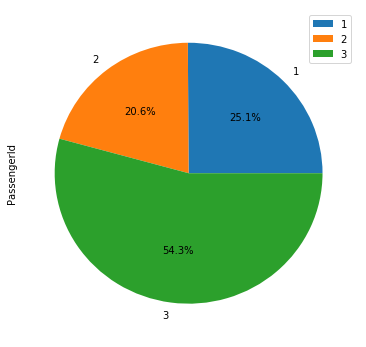

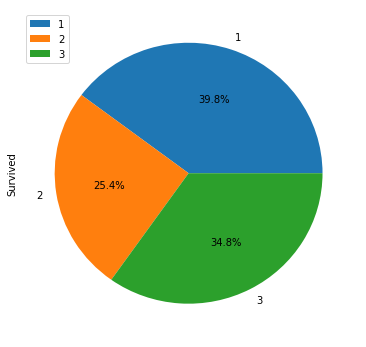

In [10]:
df_work.groupby(df_work.Pclass).sum().plot.pie('PassengerId', figsize=(6,6),autopct='%1.1f%%')
df_work.groupby(df_work.Pclass).sum().plot.pie('Survived', figsize=(6,6),autopct='%1.1f%%')

As we can see, almost half of the passengers were from the third class, however, almost half of the survivors were of the first class. Also, the survivorship rate between second and third class is almost the same.

#### Embark location

I doubt it, however, let's see if we can find anything useful using where the person embarked.

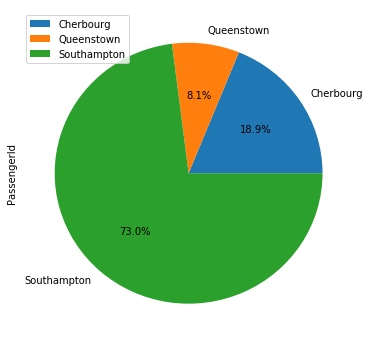

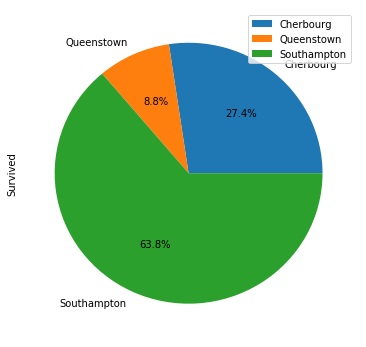

In [11]:
df_work.groupby(df_work.Embarked).sum().plot.pie('PassengerId', figsize=(6,6),autopct='%1.1f%%')
df_work.groupby(df_work.Embarked).sum().plot.pie('Survived', figsize=(6,6),autopct='%1.1f%%')

As we can see, there is no significant difference between the percentages of survivors and the total of the ship for us to infer anything, as expected.

#### Age distribuition

Let's see how age was distributed in the ship at the moment of the accident

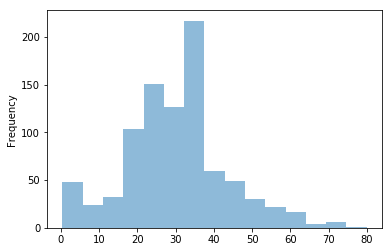

In [12]:
df_work.Age.plot.hist(bins = 15, alpha=0.5)

### Treating the Data

We need to treat our data before we apply some of our classification algorithms.

#### Transforming non-numbered values into numbered values

This is done because we cannot classify non-numbered values. So our columns like Embarked should be transformed into numbers for us to apply our methods. The relation used is shown below.

Male -> 0 / Female -> 1

For the Embark Location and the PClass we are going to use dummie variables

In [13]:
# Dealing with the sex
map_sex = {'male': 0, 'female': 1}
df_work['Sex'] = df_work['Sex'].map(map_sex)

In [14]:
# Dealing with the PClass
dummies = pd.get_dummies(df_work['Pclass'], prefix='Pclass')
df_work = pd.concat([df_work,dummies],axis=1)

In [15]:
# Dealing with the Embarked
dummies = pd.get_dummies(df_work['Embarked'], prefix='Embarked')
df_work = pd.concat([df_work,dummies],axis=1)

In [16]:
df_work

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Embarked,Title,Pclass_1,Pclass_2,Pclass_3,Embarked_Cherbourg,Embarked_Queenstown,Embarked_Southampton
0,1,0,3,"Braund, Mr. Owen Harris",0,22.000000,1,0,Southampton,Mr,0,0,1,0,0,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,38.000000,1,0,Cherbourg,Mrs,1,0,0,1,0,0
2,3,1,3,"Heikkinen, Miss. Laina",1,26.000000,0,0,Southampton,Miss,0,0,1,0,0,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,35.000000,1,0,Southampton,Mrs,1,0,0,0,0,1
4,5,0,3,"Allen, Mr. William Henry",0,35.000000,0,0,Southampton,Mr,0,0,1,0,0,1
5,6,0,3,"Moran, Mr. James",0,32.662162,0,0,Queenstown,Mr,0,0,1,0,1,0
6,7,0,1,"McCarthy, Mr. Timothy J",0,54.000000,0,0,Southampton,Mr,1,0,0,0,0,1
7,8,0,3,"Palsson, Master. Gosta Leonard",0,2.000000,3,1,Southampton,Master,0,0,1,0,0,1
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",1,27.000000,0,2,Southampton,Mrs,0,0,1,0,0,1
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",1,14.000000,1,0,Cherbourg,Mrs,0,1,0,1,0,0


#### Normalizing the Data

We are going to normalize the data because of the great range of values

In [17]:
from sklearn import preprocessing

# Create x, where x the 'scores' column's values as floats
age = df_work[['Age']].values.astype(float)

# Create a minimum and maximum processor object
min_max_scaler = preprocessing.MinMaxScaler()

# Create an object to transform the data to fit minmax processor
age_scaled = min_max_scaler.fit_transform(age)

# Run the normalizer on the dataframe
df_work['Age'] = pd.DataFrame(age_scaled)

# Something happened and NaN ages appeared, will solve it later
df_work = df_work.dropna(how='any')
df_work.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 889 entries, 0 to 890
Data columns (total 16 columns):
PassengerId             889 non-null int64
Survived                889 non-null int64
Pclass                  889 non-null int64
Name                    889 non-null object
Sex                     889 non-null int64
Age                     889 non-null float64
SibSp                   889 non-null int64
Parch                   889 non-null int64
Embarked                889 non-null object
Title                   889 non-null object
Pclass_1                889 non-null uint8
Pclass_2                889 non-null uint8
Pclass_3                889 non-null uint8
Embarked_Cherbourg      889 non-null uint8
Embarked_Queenstown     889 non-null uint8
Embarked_Southampton    889 non-null uint8
dtypes: float64(1), int64(6), object(3), uint8(6)
memory usage: 81.6+ KB


Now, we are going to index our dataframe based on the passengerId so it does not screws up our analysis.

In [18]:
df_work = df_work.set_index(['PassengerId'])

### Applying the K-Nearest Neighbors

Now we can apply the K-Nearest Neighbors to our problem. 

To maintain simplicity and to verify our results, I am not going to use the Titanic Test Dataset yet, but will divide the dataset we already have into train and test set.

Then, we need to separate our values of interest (what we will call X) and the label aka the result (what we will call y)

In [19]:
from sklearn.model_selection import train_test_split

# df is our dataframe without the Survived, Title, Embarked and Name columns
df = df_work.drop(['Survived', 'Title', 'Name', 'Embarked'], axis=1)
y = df_work['Survived']

# This function returns an division in our dataset so we can train and test our algorithm
X_train, X_test, y_train, y_test = train_test_split(df, y, test_size=0.2)

In [20]:
from sklearn.neighbors import KNeighborsClassifier

# Here we create a classifier with 5 neighbors and then fit it with the training data
neighbors = KNeighborsClassifier(n_neighbors = 5)
neighbors.fit(X_train,y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')

In [21]:
# We make the prediction and then see how much it scored
y_predicted = neighbors.predict(X_test)
print(neighbors.score(X_test, y_test))

0.7865168539325843


In [22]:
# Now we are going to see the confusion matrix of our implementation. The sum of the positions [0][0] and [1][1] is the
# amount of right choices we made. The sum of the other diagonal is our incorrect guesses.

from sklearn.metrics import confusion_matrix
conf_matrix = confusion_matrix(y_test,y_predicted)
print(conf_matrix)

[[90 18]
 [20 50]]


### Making a cross validation of our results

In [23]:
from sklearn.model_selection import cross_val_score

knn = KNeighborsClassifier();
scores = cross_val_score(knn, df, y, cv=10)
print(scores.mean())

0.786299795709908


## Using a Decision Tree

Now we are going to use a decision tree to see if it scores better or worse than KNN.

In [24]:
from sklearn.tree import DecisionTreeClassifier

dtree = DecisionTreeClassifier()
dtree.fit(X_train,y_train)
y_predicted = dtree.predict(X_test)
print(dtree.score(X_test, y_test))

0.7921348314606742


In [25]:
# Now, making a cross validation
dtree = DecisionTreeClassifier()
scores = cross_val_score(dtree, df, y, cv=10)
print(scores.mean())

0.7806818181818181


As we can see, our decision tree had a lower score than the KNN. This may be because of overfitting? Let's use a random forest and see what happens.

## Using a Random Forest

In [26]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier()
rf.fit(X_train,y_train)
y_predicted = rf.predict(X_test)
print(rf.score(X_test,y_test))

0.8202247191011236


/home/tiago/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [27]:
# Now, making a cross validation
rf = RandomForestClassifier()
scores = cross_val_score(rf, df, y, cv=10)
print(scores.mean())

0.7942415730337078


Random Forest gave us the best value, with an improvement of more than 1% over the KNN.

### Analysis and Conclusion

This an great improvement from my previous attempt. We can see that by the mean value of my cross validation. There is room for improvement, of course.

This version implements some really important concepts and has helped me to understand more in depth the nuances of dealing with data. 

In future versions I hope to use others classification algorithms. Maybe also see the influence of changing the K on the KNN. Soon I will submit it on Kaggle and see what happens with the unknown dataset.

# Kaggle Submission

Here I'm going to make the archive that I'm going to submit on Kaggle

In [28]:
# Reading the Dataframe
test = pd.read_csv('data/test.csv')

# Dropping the useless columns
df_work = test.drop(['Ticket','Fare', 'Cabin'],axis=1)

# Dealing with missing values
df_work['Title'] = 0
df_work['Title'] = df_work.Name.str.extract('([A-Za-z]+)\.')
titles_from = ['Dr', 'Rev', 'Major', 'Col', 'Mlle', 'Don', 'Lady', 'Ms', 'Mme', 'Sir', 'Jonkheer', 'Capt', 'Countess','Dona']
titles_to = ['Mr', 'Other', 'Other', 'Other', 'Miss', 'Mr', 'Mrs', 'Miss', 'Miss', 'Mr', 'Other', 'Mr', 'Mrs','Mrs']
df_work['Title'].replace(titles_from, titles_to, inplace=True)
print(df_work['Title'].value_counts())

# Once done that, we can treat the age

df_work.loc[((df_work.Age.isnull()) & (df_work.Title == 'Mr')),'Age'] = df_work.Age[df_work['Title'] == 'Mr'].mean()
df_work.loc[((df_work.Age.isnull()) & (df_work.Title == 'Miss')),'Age'] = df_work.Age[df_work['Title'] == 'Miss'].mean()
df_work.loc[((df_work.Age.isnull()) & (df_work.Title == 'Mrs')),'Age'] = df_work.Age[df_work['Title'] == 'Mrs'].mean()
df_work.loc[((df_work.Age.isnull()) & (df_work.Title == 'Master')),'Age'] = df_work.Age[df_work['Title'] == 'Master'].mean()
df_work.loc[((df_work.Age.isnull()) & (df_work.Title == 'Other')),'Age'] = df_work.Age[df_work['Title'] == 'Other'].mean()

df_work.info()

df_work = df_work.replace({"C":"Cherbourg", "Q":"Queenstown", "S":"Southampton"})
df_work.head(5)

# Dealing with the sex
map_sex = {'male': 0, 'female': 1}
df_work['Sex'] = df_work['Sex'].map(map_sex)

# Dealing with the PClass
dummies = pd.get_dummies(df_work['Pclass'], prefix='Pclass')
df_work = pd.concat([df_work,dummies],axis=1)

# Dealing with the Embarked
dummies = pd.get_dummies(df_work['Embarked'], prefix='Embarked')
df_work = pd.concat([df_work,dummies],axis=1)

# Create x, where x the 'scores' column's values as floats
age = df_work[['Age']].values.astype(float)

# Create a minimum and maximum processor object
min_max_scaler = preprocessing.MinMaxScaler()

# Create an object to transform the data to fit minmax processor
age_scaled = min_max_scaler.fit_transform(age)

# Run the normalizer on the dataframe
df_work['Age'] = pd.DataFrame(age_scaled)

# Something happened and NaN ages appeared, will solve it later
df_work = df_work.dropna(how='any')
df_work.info()

df_final = pd.DataFrame(df_work['PassengerId'])
df_work = df_work.set_index(['PassengerId'])

Mr        241
Miss       79
Mrs        73
Master     21
Other       4
Name: Title, dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 9 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null object
Sex            418 non-null object
Age            418 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Embarked       418 non-null object
Title          418 non-null object
dtypes: float64(1), int64(4), object(4)
memory usage: 29.5+ KB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 418 entries, 0 to 417
Data columns (total 15 columns):
PassengerId             418 non-null int64
Pclass                  418 non-null int64
Name                    418 non-null object
Sex                     418 non-null int64
Age                     418 non-null float64
SibSp                   418 non-null int64
Parch                   418 non-null int64
Embarked        

In [29]:
rf = RandomForestClassifier()
rf.fit(df,y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [30]:
df_work = df_work.drop(['Title', 'Name', 'Embarked'], axis=1)
y_predicted = rf.predict(df_work)

In [31]:
y_predicted

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0,
       1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1,
       1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1,
       1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0,
       1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0,
       0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0,
       0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0,
       1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1,
       0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0,
       0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,

In [32]:
df_final['Survived'] = y_predicted

In [33]:
df_final.to_csv("data/submission.csv", index = False)

This random forest implementation scored 77% on the Kaggle website. It is not a very good value, however, this was my first try. I pretend to revisit this dataset and this competition in the future, when I am more skilled. For now, I am going to keep learning and doing other competitions in order to become better and better.